여러 예측기의 예측을 모아 어떤 방법으로 예측을 최종 선택하는 방법을 앙상을 방법이라 한다. 결정 트리의 앙상블이 랜덤 포레스트이다.

Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

투표 기반 분류기

매우 간단한 분류기 앙상블 방법은 여러 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다. 이런 다수결 분류기를 직접 투표 분류기라 한다.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [5]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


투표 기반 분류기의 성능이 다른 개별 분류기보다 높은 것을 확인할 수 있다.

위에서 voting="soft"로 바꾸면 각 클래스의 예측 확률의 평균으로 최종 예측을 정할 수 있다. 이를 간접 투표라고 한다. 하지만 SVC는 기본적으로 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 한다.

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


배깅, 페이스팅

다양한 분류기를 만들기 만들기 위해 각기 다른 모델을 사용할 수도 있지만, 같은 알고리즘을 사용하되 훈련 세트의 서브셋을 무작위로 구성하여 각기 다르게 학습시킬 수도 있다. 이 때 서브셋간의 데이터 중복을 허용하면 배깅, 허용하지 않으면 페이스팅이라 한다.

이렇게 만들어진 예측기의 예측은 수집 함수를 통과해 최종 예측이 된다. 수집 함수는 보통 분류일 때는 통계적 최빈값, 회귀일 때는 평균이다. 개별 예측기는 원본으로 훈련시킨 예측기보다 편향이 크지만 수집 함수를 통과하면 편향과 분산이 감소한다. 최종적으로 편향은 원본으로 훈련시킨 예측기와 비슷해지고 분산은 줄어든다(즉 오차율은 비슷하지만 더 잘 일반된 모델이 만들어진다).

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


사이킷런은 배깅과 페이스팅을 위한 BaggingClassifier, BaggingRegressor을 제공한다.

다음은 결정 트리가 분류기 500개의 앙상블을 훈련시키는 코드다. 중복을 허용한 100개의 샘플로 훈련된다(배깅). 만약 페이스팅을 사용하고 싶다면 bootstrap=False로 지정하면 된다. n_jobs는 사용할 CPU 코어 수를 지정한다. -1일 때 가용한 모든 코어를 사용한다.

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

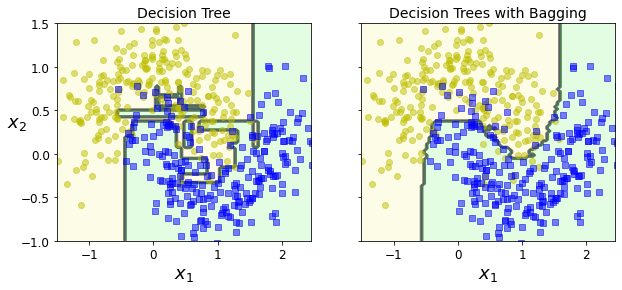

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

배깅을 사용하여 훈련할 때 샘플은 무작위로 선택된다. 이 때 평균적으로 63%가 사용되고 37%는 남겨진다. 이렇게 남겨진 샘플을 oob 샘플리라 부른다. 예측기 훈련에 사용되지 않았으므로 우리는 이 oob샘플을 가지고 예측기를 평가할 수 있다. oob_score=True로 지정시 훈련 종료 후 자동으로 oob 평가를 수행한다.

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

이를통해 학습된 예측기는 약 0.8987의 정확도를 가질 것이라 예상할 수 있다. 다음은 실제 정확도이다.

In [15]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

랜덤 패치, 랜덤 서브스페이스

BaggingClassifier은 특성 샘플링을 지원한다(max_features, bootstrap_features). 이 기법은 고차원 데이터셋을 다룰 때 유용하다.

훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치 방식이라 하고, 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것을 랜덤 서브스페이스 방식이라 한다. 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

랜덤 포레스트

랜덤 포레스트는 결정 트리의 앙상블이다. 다음은 랜덤 포레스트 분류기를 모든 CPU코어를 사용해 훈련시키는 코드이다.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

다음은 BaggingClassifier를 사용해 위 RandomForestClassifier와 거의 유사하게 만든 것이다.

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [18]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

두 모델의 예측이 동일함을 확인할 수 있다.

랜덤 포레스트는 트리 노드를 분할할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위 선택된 특성군 중에서 최적의 특성을 찾는 것으로 무작위성을 확보한다. 이는 트리를 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다. 트리를 만들 때 여기서 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택할 수 있다. 이같이 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리(줄여서 엑스트라 트리)라고 한다. 여기서고 역시 편향이 늘어나지만 분산을 낮추게 된다.

엑스트라 트리는 사이킷런의 ExtraTreeClassifier로 만들 수 있다.

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중료도를 측정하기 쉽다는 것이다. 노드가 사용한 특성이 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. 이는 가중치 평균이며 각 노드의 가중치는 연관된 샘플 수와 같다. 사이킷런은 훈련이 끝나고 자동으로 이 점수를 계산하여 합이 1이 되도록 정규화한다. 이는 feature_importances_ 변수에 저장되어 있따.

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


MNIST 데이터셋을 랜덤 포레스트 분류기에 학습시키고 각 픽셀별 중요도를 그래프로 나타내보자.

In [21]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [22]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [23]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

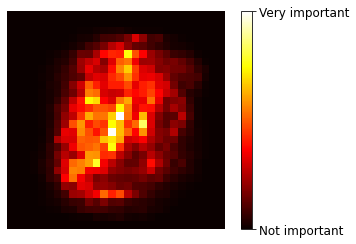

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()